In [1]:
# Parameters (overridden during execution)
EPOCHS = 30
RUN_ID = 1
OUT_DIR = "/kaggle/working/outputs"

In [2]:
!pip install torchinfo
!pip install --quiet torchview graphviz

In [3]:
import os
import math
import time
import random
import multiprocessing
from datetime import timedelta
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG, display

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from timm.models.vision_transformer import VisionTransformer, PatchEmbed
from torchinfo import summary
from torchview import draw_graph

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import random_split
from collections import Counter

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [7]:
# -------------------------
# Config (dynamic params)
# -------------------------
BATCH_SIZE = 6
IMG_SIZE   = 224

# -------------------------
# Load data
# -------------------------
# data = np.load("/kaggle/input/pneumoniamnist.npz")
''''''




''

In [8]:
train_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)


print(train_df.shape)
train_df.head()


(30227, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [9]:
df = (
    train_df
    .groupby("patientId")["Target"]
    .max()
    .reset_index()
    .rename(columns={"Target": "label"})
)

print("Raw rows:", len(train_df))
print("Unique images:", len(df))

Raw rows: 30227
Unique images: 26684


In [10]:
from sklearn.model_selection import train_test_split

# First split: Train vs Temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)

# Second split: Val vs Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (18678, 2)
Val: (4003, 2)
Test: (4003, 2)


In [11]:
import os
import pydicom
import numpy as np
import random

TRAIN_IMG_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"


In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

In [13]:
def show_random_images_per_class(
    dataset,
    class_names,
    n_per_class=5,
    seed=42,
    image_names=None
):
    """
    Displays n random images per class in an m x n grid.
    If image_names is None, uses ClassName_index.
    """

    random.seed(seed)
    torch.manual_seed(seed)

    labels = dataset.labels.cpu().numpy()
    images = dataset.images.cpu()
    num_classes = len(class_names)

    class_indices = [
        np.where(labels == c)[0]
        for c in range(num_classes)
    ]

    fig, axes = plt.subplots(
        num_classes,
        n_per_class,
        figsize=(3 * n_per_class, 3 * num_classes),
        squeeze=False
    )

    for cls in range(num_classes):
        idxs = class_indices[cls]
        k = min(n_per_class, len(idxs))
        selected = np.random.choice(idxs, size=k, replace=False)

        for col, idx in enumerate(selected):
            img = images[idx].permute(1, 2, 0).numpy()
            img = img / 255.0  # correct float range for imshow

            ax = axes[cls, col]
            ax.imshow(img)
            ax.axis("off")

            # Image title
            if image_names is not None:
                title = image_names[idx]
            else:
                title = f"{class_names[cls]}_{idx}"

            ax.set_title(title, fontsize=9)

            if col == 0:
                ax.set_ylabel(
                    class_names[cls],
                    rotation=90,
                    fontsize=12,
                    labelpad=10
                )

    plt.tight_layout()
    plt.show()

class_names = ["Normal", "Pneumonia"]

show_random_images_per_class(
    train_dataset,
    class_names=class_names,
    n_per_class=5
)

NameError: name 'train_dataset' is not defined

In [13]:
import os
import torch
import pydicom
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [14]:
class RSNAPneumoniaDataset(Dataset):
    def __init__(self, df, image_dir, img_size):
        """
        df: DataFrame with columns ['patientId', 'label']
        image_dir: directory containing .dcm files
        img_size: target image size (e.g., 224)
        """
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def load_dicom(self, path):
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array.astype(np.float32)

        # Normalize per image (important for RSNA)
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

        return img

    def __getitem__(self, idx):
        patient_id = self.df.loc[idx, "patientId"]
        label = self.df.loc[idx, "label"]

        dcm_path = os.path.join(self.image_dir, f"{patient_id}.dcm")

        # Load image
        img = self.load_dicom(dcm_path)

        # (H, W) → (1, H, W)
        img = torch.from_numpy(img).unsqueeze(0)

        # Grayscale → RGB
        img = img.repeat(3, 1, 1)   # (3, H, W)

        # Resize
        img = F.interpolate(
            img.unsqueeze(0),
            size=(self.img_size, self.img_size),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        return img, torch.tensor(label, dtype=torch.long)


In [15]:
IMAGE_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"
IMG_SIZE = 224
BATCH_SIZE = 6


In [16]:
import cv2

In [17]:
train_dataset = RSNAPneumoniaDataset(train_df, IMAGE_DIR, IMG_SIZE)
val_dataset   = RSNAPneumoniaDataset(val_df,   IMAGE_DIR, IMG_SIZE)
test_dataset  = RSNAPneumoniaDataset(test_df,  IMAGE_DIR, IMG_SIZE)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [19]:
class CNN_ViT_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        pretrained_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        num_blocks1 = len(pretrained_model.features)

        for param in pretrained_model.features[:num_blocks1 // 2].parameters():
            param.requires_grad = False

        self.mobilenet_feature_blocks_1 = nn.Sequential(*pretrained_model.features[:num_blocks1 - 3])
        self.mobilenet_block_2nd_last = pretrained_model.features[num_blocks1 - 3]
        self.mobilenet_block_mid = pretrained_model.features[num_blocks1 - 2]
        self.mobilenet_block_last = pretrained_model.features[num_blocks1 - 1]

        ch_2nd_last = self.mobilenet_block_2nd_last.out_channels
        ch_last = self.mobilenet_block_last.out_channels
        ch_mid = self.mobilenet_block_mid.out_channels
        ch_concat = ch_last + ch_2nd_last

        # CNN → ViT adapter (GELU REMOVED)
        self.cnn_to_vit_adapter = nn.Sequential(
            nn.Conv2d(ch_mid, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Upsample(size=(14, 14), mode="bilinear", align_corners=False),
            nn.Conv2d(64, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False),
            nn.Conv2d(32, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(inplace=True),
            nn.Upsample(size=(56, 56), mode="bilinear", align_corners=False),
        )

        self.vit_encoder1 = VisionTransformer(
            img_size=56, patch_size=8, in_chans=16,
            num_classes=0, embed_dim=64,
            depth=2, num_heads=4, mlp_ratio=2,
            qkv_bias=True, norm_layer=nn.LayerNorm,
        )
        self.vit_encoder1.head = nn.Identity()

        old_proj = self.vit_encoder1.patch_embed.proj
        self.vit_encoder1.patch_embed.proj = nn.Conv2d(
            old_proj.in_channels, old_proj.out_channels,
            kernel_size=8, stride=4,
            bias=old_proj.bias is not None,
        )

        img_h, img_w = self.vit_encoder1.patch_embed.img_size
        dummy = torch.zeros(1, old_proj.in_channels, img_h, img_w)
        with torch.no_grad():
            _, _, h, w = self.vit_encoder1.patch_embed.proj(dummy).shape

        num_patches = h * w
        self.vit_encoder1.patch_embed.num_patches = num_patches
        self.vit_encoder1.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, self.vit_encoder1.embed_dim)
        )
        nn.init.trunc_normal_(self.vit_encoder1.pos_embed, std=0.02)

        self.vit_encoder2 = VisionTransformer(
            img_size=28, patch_size=7, in_chans=32,
            num_classes=0, embed_dim=64,
            depth=2, num_heads=4, mlp_ratio=2,
            qkv_bias=True, norm_layer=nn.LayerNorm,
        )
        self.vit_encoder2.head = nn.Identity()

        self.cnn_parallel_head = nn.Sequential(
            nn.Conv2d(ch_concat, 96, 1), nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3), nn.BatchNorm2d(96), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        )

        self.classifier_head = nn.Linear(64 + 64 + 96, num_classes)

    def forward(self, x):
        f1 = self.mobilenet_feature_blocks_1(x)
        f2 = self.mobilenet_block_2nd_last(f1)
        fmid = self.mobilenet_block_mid(f2)
        flast = self.mobilenet_block_last(fmid)

        cnn_concat = torch.cat([flast, f2], dim=1)

        x = fmid
        intermediate = None
        for i, layer in enumerate(self.cnn_to_vit_adapter):
            x = layer(x)
            if i == len(self.cnn_to_vit_adapter) - 5:
                intermediate = x

        vit_features1 = self.vit_encoder1(x)
        vit_features2 = self.vit_encoder2(intermediate)

        cnn_features = self.cnn_parallel_head(cnn_concat)

        combined = torch.cat([vit_features1, vit_features2, cnn_features], dim=1)
        return self.classifier_head(combined)


In [20]:
model = CNN_ViT_Model(num_classes=2)
summary(model, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 179MB/s]


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
CNN_ViT_Model                                      [1, 3, 224, 224]          [1, 2]                    --                        Partial
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 160, 7, 7]            --                        Partial
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual: 2-2                      

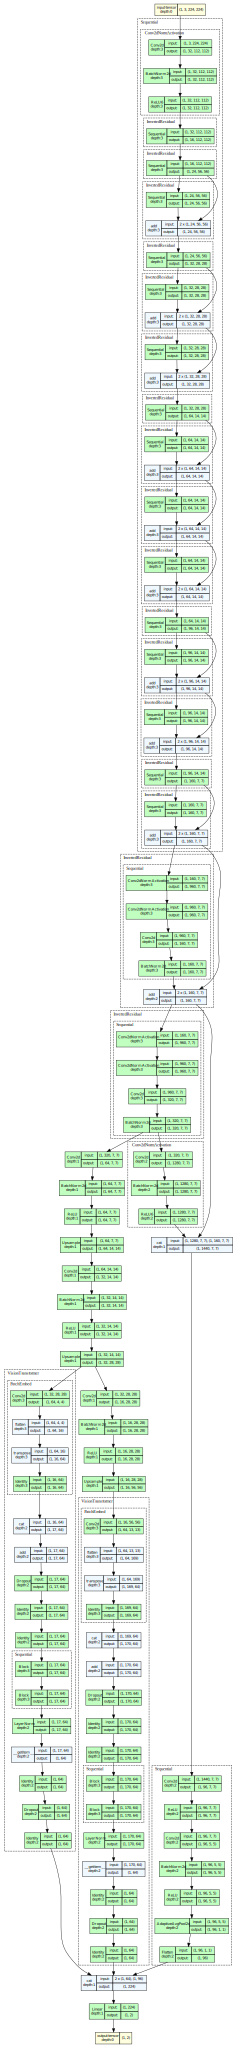

In [21]:
model.to(device)

# Dummy input (can adjust shape based on your model's expected input)
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Generate the graph — expand_nested=True if model has nested submodules
model_graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    graph_name="CNN_ViT_Model",
    save_graph=False  # We don't want to save, only display inline
)

# Render to SVG and display inline in the notebook
svg_output = model_graph.visual_graph.pipe(format='svg')
display(SVG(svg_output))

In [22]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0.0

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()

        # Skip AUC if only one class is present
        if np.unique(class_y_true).size < 2:
            continue
        try:
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        except ValueError:
            continue

    auc_avg = np.mean(auc_scores) if auc_scores else 0.0

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [23]:
# Hyperparameters
num_epochs       = EPOCHS
initial_lr       = 1e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [24]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric: [] for metric in metric_names}
val_metrics_history = {metric: [] for metric in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training loop
    model.train()
    total_train_loss = 0.0
    all_train_predictions = []
    all_train_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        all_train_predictions.extend(outputs.detach().cpu().numpy())
        all_train_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    average_train_loss = total_train_loss / len(train_loader)
    all_train_predictions = np.array(all_train_predictions)
    all_train_targets = np.array(all_train_targets)

    train_metrics = custom_metrics(torch.tensor(all_train_predictions), torch.tensor(all_train_targets), average_train_loss)
    training_metrics_line = "Train Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(training_metrics_line)

    for metric in metric_names:
        train_metrics_history[metric].append(train_metrics[metric])

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    all_val_predictions = []
    all_val_targets = []
    start_val_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            all_val_predictions.extend(outputs.detach().cpu().numpy())
            all_val_targets.extend(targets.detach().cpu().numpy())

    end_val_time = time.time()
    epoch_validation_time = end_val_time - start_val_time
    total_validation_time += epoch_validation_time

    average_val_loss = total_val_loss / len(val_loader)
    all_val_predictions = np.array(all_val_predictions)
    all_val_targets = np.array(all_val_targets)

    val_metrics = custom_metrics(torch.tensor(all_val_predictions), torch.tensor(all_val_targets), average_val_loss)
    validation_metrics_line = "Val Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(validation_metrics_line)

    for metric in metric_names:
        val_metrics_history[metric].append(val_metrics[metric])

    # Update LR via scheduler rather than manual mutliplication
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.4f} — LR: {current_lr:.6f}")

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / (epoch + 1)
avg_validation_time_per_epoch = total_validation_time / (epoch + 1)
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Epoch [1/30]: 100%|██████████| 3113/3113 [04:20<00:00, 11.96it/s]


Train Metrics - loss: 0.4117, accuracy: 0.8148, precision: 0.7980, recall: 0.8148, f1_score: 0.7985, specificity: 0.9342, sensitivity: 0.4042, mcc: 0.4050, auc: 0.8185


Validating Model: 100%|██████████| 668/668 [00:56<00:00, 11.74it/s]


Val Metrics - loss: 0.3644, accuracy: 0.8416, precision: 0.8316, recall: 0.8416, f1_score: 0.8322, specificity: 0.9371, sensitivity: 0.5133, mcc: 0.5078, auc: 0.8652
Epoch 0/30 — Loss: 0.0808 — LR: 0.000100


Training Epoch [2/30]: 100%|██████████| 3113/3113 [02:50<00:00, 18.27it/s]


Train Metrics - loss: 0.3612, accuracy: 0.8393, precision: 0.8296, recall: 0.8393, f1_score: 0.8312, specificity: 0.9306, sensitivity: 0.5254, mcc: 0.5047, auc: 0.8685


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.81it/s]


Val Metrics - loss: 0.3601, accuracy: 0.8404, precision: 0.8314, recall: 0.8404, f1_score: 0.8334, specificity: 0.9274, sensitivity: 0.5410, mcc: 0.5115, auc: 0.8696
Epoch 1/30 — Loss: 0.1812 — LR: 0.000100


Training Epoch [3/30]: 100%|██████████| 3113/3113 [02:49<00:00, 18.38it/s]


Train Metrics - loss: 0.3195, accuracy: 0.8609, precision: 0.8549, recall: 0.8609, f1_score: 0.8563, specificity: 0.9341, sensitivity: 0.6093, mcc: 0.5806, auc: 0.8994


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.89it/s]


Val Metrics - loss: 0.3722, accuracy: 0.8326, precision: 0.8210, recall: 0.8326, f1_score: 0.8223, specificity: 0.9326, sensitivity: 0.4889, mcc: 0.4775, auc: 0.8580
Epoch 2/30 — Loss: 0.4058 — LR: 0.000100


Training Epoch [4/30]: 100%|██████████| 3113/3113 [02:52<00:00, 18.03it/s]


Train Metrics - loss: 0.2594, accuracy: 0.8917, precision: 0.8892, recall: 0.8917, f1_score: 0.8900, specificity: 0.9420, sensitivity: 0.7186, mcc: 0.6814, auc: 0.9369


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.98it/s]


Val Metrics - loss: 0.4281, accuracy: 0.8299, precision: 0.8229, recall: 0.8299, f1_score: 0.8255, specificity: 0.9094, sensitivity: 0.5565, mcc: 0.4908, auc: 0.8509
Epoch 3/30 — Loss: 0.9223 — LR: 0.000100


Training Epoch [5/30]: 100%|██████████| 3113/3113 [02:47<00:00, 18.59it/s]


Train Metrics - loss: 0.1918, accuracy: 0.9230, precision: 0.9223, recall: 0.9230, f1_score: 0.9226, specificity: 0.9541, sensitivity: 0.8158, mcc: 0.7773, auc: 0.9660


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.83it/s]


Val Metrics - loss: 0.5376, accuracy: 0.8041, precision: 0.7930, recall: 0.8041, f1_score: 0.7970, specificity: 0.8997, sensitivity: 0.4756, mcc: 0.4040, auc: 0.8048
Epoch 4/30 — Loss: 0.8696 — LR: 0.000100


Training Epoch [6/30]: 100%|██████████| 3113/3113 [02:46<00:00, 18.72it/s]


Train Metrics - loss: 0.1405, accuracy: 0.9446, precision: 0.9445, recall: 0.9446, f1_score: 0.9446, specificity: 0.9648, sensitivity: 0.8752, mcc: 0.8411, auc: 0.9819


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.23it/s]


Val Metrics - loss: 0.6514, accuracy: 0.8086, precision: 0.7956, recall: 0.8086, f1_score: 0.7995, specificity: 0.9094, sensitivity: 0.4623, mcc: 0.4093, auc: 0.7848
Epoch 5/30 — Loss: 1.4392 — LR: 0.000100


Training Epoch [7/30]: 100%|██████████| 3113/3113 [02:48<00:00, 18.46it/s]


Train Metrics - loss: 0.1043, accuracy: 0.9588, precision: 0.9587, recall: 0.9588, f1_score: 0.9587, specificity: 0.9744, sensitivity: 0.9049, mcc: 0.8816, auc: 0.9902


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.42it/s]


Val Metrics - loss: 0.6057, accuracy: 0.7902, precision: 0.7937, recall: 0.7902, f1_score: 0.7918, specificity: 0.8578, sensitivity: 0.5576, mcc: 0.4089, auc: 0.8041
Epoch 6/30 — Loss: 0.0273 — LR: 0.000100


Training Epoch [8/30]: 100%|██████████| 3113/3113 [02:48<00:00, 18.52it/s]


Train Metrics - loss: 0.0941, accuracy: 0.9642, precision: 0.9642, recall: 0.9642, f1_score: 0.9642, specificity: 0.9776, sensitivity: 0.9183, mcc: 0.8974, auc: 0.9917


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.33it/s]


Val Metrics - loss: 0.6912, accuracy: 0.7887, precision: 0.8039, recall: 0.7887, f1_score: 0.7948, specificity: 0.8362, sensitivity: 0.6253, mcc: 0.4354, auc: 0.8135
Epoch 7/30 — Loss: 0.5621 — LR: 0.000100


Training Epoch [9/30]: 100%|██████████| 3113/3113 [02:50<00:00, 18.22it/s]


Train Metrics - loss: 0.0845, accuracy: 0.9671, precision: 0.9672, recall: 0.9671, f1_score: 0.9671, specificity: 0.9783, sensitivity: 0.9287, mcc: 0.9059, auc: 0.9932


Validating Model: 100%|██████████| 668/668 [00:36<00:00, 18.42it/s]


Val Metrics - loss: 0.7034, accuracy: 0.8119, precision: 0.8018, recall: 0.8119, f1_score: 0.8053, specificity: 0.9036, sensitivity: 0.4967, mcc: 0.4292, auc: 0.8011
Epoch 8/30 — Loss: 0.0125 — LR: 0.000100


Training Epoch [10/30]: 100%|██████████| 3113/3113 [02:54<00:00, 17.82it/s]


Train Metrics - loss: 0.0754, accuracy: 0.9712, precision: 0.9712, recall: 0.9712, f1_score: 0.9712, specificity: 0.9820, sensitivity: 0.9344, mcc: 0.9175, auc: 0.9945


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.33it/s]


Val Metrics - loss: 0.8021, accuracy: 0.8179, precision: 0.8052, recall: 0.8179, f1_score: 0.8083, specificity: 0.9181, sensitivity: 0.4734, mcc: 0.4353, auc: 0.8103
Epoch 9/30 — Loss: 0.0088 — LR: 0.000100


Training Epoch [11/30]: 100%|██████████| 3113/3113 [02:46<00:00, 18.74it/s]


Train Metrics - loss: 0.0654, accuracy: 0.9757, precision: 0.9757, recall: 0.9757, f1_score: 0.9757, specificity: 0.9852, sensitivity: 0.9432, mcc: 0.9304, auc: 0.9956


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.86it/s]


Val Metrics - loss: 0.7266, accuracy: 0.8081, precision: 0.7972, recall: 0.8081, f1_score: 0.8010, specificity: 0.9026, sensitivity: 0.4834, mcc: 0.4159, auc: 0.8002
Epoch 10/30 — Loss: 0.0752 — LR: 0.000097


Training Epoch [12/30]: 100%|██████████| 3113/3113 [02:46<00:00, 18.73it/s]


Train Metrics - loss: 0.0550, accuracy: 0.9789, precision: 0.9788, recall: 0.9789, f1_score: 0.9788, specificity: 0.9875, sensitivity: 0.9491, mcc: 0.9393, auc: 0.9970


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.45it/s]


Val Metrics - loss: 0.8080, accuracy: 0.8214, precision: 0.8088, recall: 0.8214, f1_score: 0.8116, specificity: 0.9216, sensitivity: 0.4767, mcc: 0.4450, auc: 0.8073
Epoch 11/30 — Loss: 0.3434 — LR: 0.000094


Training Epoch [13/30]: 100%|██████████| 3113/3113 [02:46<00:00, 18.65it/s]


Train Metrics - loss: 0.0485, accuracy: 0.9824, precision: 0.9824, recall: 0.9824, f1_score: 0.9824, specificity: 0.9896, sensitivity: 0.9577, mcc: 0.9496, auc: 0.9976


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.85it/s]


Val Metrics - loss: 0.8627, accuracy: 0.8076, precision: 0.8124, recall: 0.8076, f1_score: 0.8098, specificity: 0.8662, sensitivity: 0.6064, mcc: 0.4621, auc: 0.8223
Epoch 12/30 — Loss: 0.5920 — LR: 0.000091


Training Epoch [14/30]: 100%|██████████| 3113/3113 [02:47<00:00, 18.58it/s]


Train Metrics - loss: 0.0483, accuracy: 0.9826, precision: 0.9826, recall: 0.9826, f1_score: 0.9826, specificity: 0.9887, sensitivity: 0.9617, mcc: 0.9502, auc: 0.9977


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.61it/s]


Val Metrics - loss: 0.8405, accuracy: 0.8166, precision: 0.7997, recall: 0.8166, f1_score: 0.7980, specificity: 0.9416, sensitivity: 0.3869, mcc: 0.4050, auc: 0.8125
Epoch 13/30 — Loss: 0.2890 — LR: 0.000089


Training Epoch [15/30]: 100%|██████████| 3113/3113 [02:46<00:00, 18.75it/s]


Train Metrics - loss: 0.0401, accuracy: 0.9860, precision: 0.9860, recall: 0.9860, f1_score: 0.9860, specificity: 0.9911, sensitivity: 0.9686, mcc: 0.9600, auc: 0.9983


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.57it/s]


Val Metrics - loss: 0.8050, accuracy: 0.8136, precision: 0.8057, recall: 0.8136, f1_score: 0.8088, specificity: 0.8991, sensitivity: 0.5200, mcc: 0.4416, auc: 0.8166
Epoch 14/30 — Loss: 0.0075 — LR: 0.000086


Training Epoch [16/30]: 100%|██████████| 3113/3113 [02:46<00:00, 18.70it/s]


Train Metrics - loss: 0.0368, accuracy: 0.9868, precision: 0.9868, recall: 0.9868, f1_score: 0.9868, specificity: 0.9920, sensitivity: 0.9691, mcc: 0.9622, auc: 0.9987


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.95it/s]


Val Metrics - loss: 0.8359, accuracy: 0.8129, precision: 0.8079, recall: 0.8129, f1_score: 0.8101, specificity: 0.8907, sensitivity: 0.5455, mcc: 0.4493, auc: 0.8134
Epoch 15/30 — Loss: 0.0022 — LR: 0.000083


Training Epoch [17/30]: 100%|██████████| 3113/3113 [02:44<00:00, 18.91it/s]


Train Metrics - loss: 0.0322, accuracy: 0.9883, precision: 0.9883, recall: 0.9883, f1_score: 0.9883, specificity: 0.9925, sensitivity: 0.9736, mcc: 0.9664, auc: 0.9990


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.72it/s]


Val Metrics - loss: 0.9840, accuracy: 0.8136, precision: 0.7973, recall: 0.8136, f1_score: 0.7992, specificity: 0.9284, sensitivity: 0.4191, mcc: 0.4067, auc: 0.8042
Epoch 16/30 — Loss: 0.0112 — LR: 0.000081


Training Epoch [18/30]: 100%|██████████| 3113/3113 [02:47<00:00, 18.56it/s]


Train Metrics - loss: 0.0300, accuracy: 0.9893, precision: 0.9893, recall: 0.9893, f1_score: 0.9893, specificity: 0.9933, sensitivity: 0.9758, mcc: 0.9695, auc: 0.9990


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.53it/s]


Val Metrics - loss: 0.8668, accuracy: 0.8186, precision: 0.8129, recall: 0.8186, f1_score: 0.8153, specificity: 0.8968, sensitivity: 0.5499, mcc: 0.4633, auc: 0.8252
Epoch 17/30 — Loss: 0.0527 — LR: 0.000078


Training Epoch [19/30]: 100%|██████████| 3113/3113 [02:46<00:00, 18.65it/s]


Train Metrics - loss: 0.0265, accuracy: 0.9902, precision: 0.9902, recall: 0.9902, f1_score: 0.9902, specificity: 0.9942, sensitivity: 0.9765, mcc: 0.9719, auc: 0.9993


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 19.07it/s]


Val Metrics - loss: 0.9805, accuracy: 0.8094, precision: 0.7944, recall: 0.8094, f1_score: 0.7979, specificity: 0.9168, sensitivity: 0.4401, mcc: 0.4031, auc: 0.8056
Epoch 18/30 — Loss: 0.6775 — LR: 0.000076


Training Epoch [20/30]: 100%|██████████| 3113/3113 [02:47<00:00, 18.59it/s]


Train Metrics - loss: 0.0245, accuracy: 0.9913, precision: 0.9913, recall: 0.9913, f1_score: 0.9913, specificity: 0.9945, sensitivity: 0.9803, mcc: 0.9751, auc: 0.9994


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.22it/s]


Val Metrics - loss: 0.9186, accuracy: 0.8126, precision: 0.8024, recall: 0.8126, f1_score: 0.8060, specificity: 0.9045, sensitivity: 0.4967, mcc: 0.4309, auc: 0.8122
Epoch 19/30 — Loss: 0.0716 — LR: 0.000074


Training Epoch [21/30]: 100%|██████████| 3113/3113 [02:48<00:00, 18.43it/s]


Train Metrics - loss: 0.0220, accuracy: 0.9927, precision: 0.9927, recall: 0.9927, f1_score: 0.9927, specificity: 0.9955, sensitivity: 0.9831, mcc: 0.9791, auc: 0.9995


Validating Model: 100%|██████████| 668/668 [00:38<00:00, 17.17it/s]


Val Metrics - loss: 1.0176, accuracy: 0.8046, precision: 0.7921, recall: 0.8046, f1_score: 0.7963, specificity: 0.9039, sensitivity: 0.4634, mcc: 0.4004, auc: 0.8096
Epoch 20/30 — Loss: 0.0788 — LR: 0.000072


Training Epoch [22/30]: 100%|██████████| 3113/3113 [02:51<00:00, 18.18it/s]


Train Metrics - loss: 0.0238, accuracy: 0.9918, precision: 0.9918, recall: 0.9918, f1_score: 0.9918, specificity: 0.9947, sensitivity: 0.9817, mcc: 0.9764, auc: 0.9993


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.36it/s]


Val Metrics - loss: 0.9521, accuracy: 0.8136, precision: 0.7997, recall: 0.8136, f1_score: 0.8030, specificity: 0.9178, sensitivity: 0.4557, mcc: 0.4189, auc: 0.8055
Epoch 21/30 — Loss: 3.7563 — LR: 0.000069


Training Epoch [23/30]: 100%|██████████| 3113/3113 [02:48<00:00, 18.45it/s]


Train Metrics - loss: 0.0187, accuracy: 0.9935, precision: 0.9935, recall: 0.9935, f1_score: 0.9935, specificity: 0.9955, sensitivity: 0.9867, mcc: 0.9815, auc: 0.9996


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.22it/s]


Val Metrics - loss: 0.9940, accuracy: 0.8106, precision: 0.7993, recall: 0.8106, f1_score: 0.8030, specificity: 0.9062, sensitivity: 0.4823, mcc: 0.4212, auc: 0.8153
Epoch 22/30 — Loss: 2.5608 — LR: 0.000067


Training Epoch [24/30]: 100%|██████████| 3113/3113 [02:51<00:00, 18.13it/s]


Train Metrics - loss: 0.0174, accuracy: 0.9942, precision: 0.9942, recall: 0.9942, f1_score: 0.9942, specificity: 0.9964, sensitivity: 0.9867, mcc: 0.9834, auc: 0.9996


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.10it/s]


Val Metrics - loss: 0.9848, accuracy: 0.8189, precision: 0.8045, recall: 0.8189, f1_score: 0.8067, specificity: 0.9268, sensitivity: 0.4479, mcc: 0.4296, auc: 0.8150
Epoch 23/30 — Loss: 0.0147 — LR: 0.000065


Training Epoch [25/30]: 100%|██████████| 3113/3113 [02:48<00:00, 18.48it/s]


Train Metrics - loss: 0.0156, accuracy: 0.9950, precision: 0.9950, recall: 0.9950, f1_score: 0.9950, specificity: 0.9968, sensitivity: 0.9888, mcc: 0.9857, auc: 0.9998


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.62it/s]


Val Metrics - loss: 1.0991, accuracy: 0.7917, precision: 0.7959, recall: 0.7917, f1_score: 0.7936, specificity: 0.8575, sensitivity: 0.5654, mcc: 0.4150, auc: 0.7893
Epoch 24/30 — Loss: 1.4980 — LR: 0.000063


Training Epoch [26/30]: 100%|██████████| 3113/3113 [02:48<00:00, 18.48it/s]


Train Metrics - loss: 0.0167, accuracy: 0.9942, precision: 0.9942, recall: 0.9942, f1_score: 0.9942, specificity: 0.9968, sensitivity: 0.9855, mcc: 0.9834, auc: 0.9997


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.24it/s]


Val Metrics - loss: 0.9426, accuracy: 0.8096, precision: 0.8095, recall: 0.8096, f1_score: 0.8096, specificity: 0.8775, sensitivity: 0.5765, mcc: 0.4543, auc: 0.8227
Epoch 25/30 — Loss: 4.9453 — LR: 0.000061


Training Epoch [27/30]: 100%|██████████| 3113/3113 [02:47<00:00, 18.54it/s]


Train Metrics - loss: 0.0127, accuracy: 0.9954, precision: 0.9954, recall: 0.9954, f1_score: 0.9954, specificity: 0.9971, sensitivity: 0.9898, mcc: 0.9870, auc: 0.9999


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.56it/s]


Val Metrics - loss: 1.0986, accuracy: 0.8151, precision: 0.8020, recall: 0.8151, f1_score: 0.8054, specificity: 0.9165, sensitivity: 0.4667, mcc: 0.4264, auc: 0.8113
Epoch 26/30 — Loss: 0.0124 — LR: 0.000060


Training Epoch [28/30]: 100%|██████████| 3113/3113 [02:48<00:00, 18.52it/s]


Train Metrics - loss: 0.0139, accuracy: 0.9945, precision: 0.9945, recall: 0.9945, f1_score: 0.9945, specificity: 0.9965, sensitivity: 0.9876, mcc: 0.9844, auc: 0.9998


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.73it/s]


Val Metrics - loss: 1.0762, accuracy: 0.8101, precision: 0.8110, recall: 0.8101, f1_score: 0.8106, specificity: 0.8755, sensitivity: 0.5854, mcc: 0.4587, auc: 0.8191
Epoch 27/30 — Loss: 0.2469 — LR: 0.000058


Training Epoch [29/30]: 100%|██████████| 3113/3113 [02:47<00:00, 18.61it/s]


Train Metrics - loss: 0.0116, accuracy: 0.9966, precision: 0.9966, recall: 0.9966, f1_score: 0.9966, specificity: 0.9978, sensitivity: 0.9924, mcc: 0.9902, auc: 0.9998


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.29it/s]


Val Metrics - loss: 1.1428, accuracy: 0.8206, precision: 0.8061, recall: 0.8206, f1_score: 0.8075, specificity: 0.9310, sensitivity: 0.4412, mcc: 0.4321, auc: 0.8107
Epoch 28/30 — Loss: 0.0009 — LR: 0.000056


Training Epoch [30/30]: 100%|██████████| 3113/3113 [02:50<00:00, 18.22it/s]


Train Metrics - loss: 0.0124, accuracy: 0.9959, precision: 0.9959, recall: 0.9959, f1_score: 0.9959, specificity: 0.9974, sensitivity: 0.9907, mcc: 0.9882, auc: 0.9999


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.71it/s]

Val Metrics - loss: 1.0899, accuracy: 0.8191, precision: 0.8057, recall: 0.8191, f1_score: 0.8084, specificity: 0.9226, sensitivity: 0.4634, mcc: 0.4352, auc: 0.8101
Epoch 29/30 — Loss: 0.0233 — LR: 0.000054
Total Training Time: 1:25:46.385472
Total Validation Time: 0:17:42.735628
Average Training Time per Epoch: 0:02:51.546182
Average Validation Time per Epoch: 0:00:35.424521


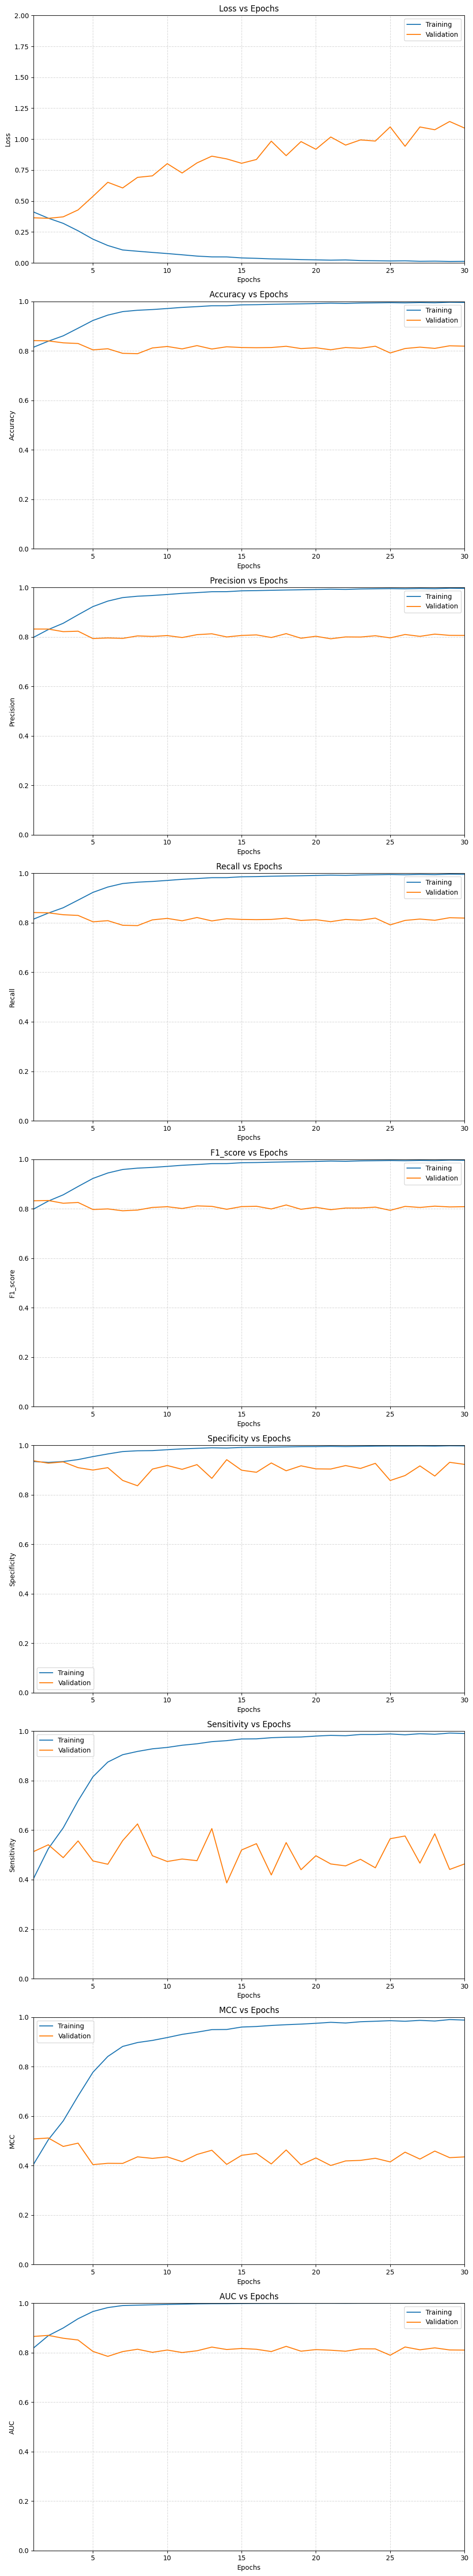

In [25]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(f"{metric_name.upper()} vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(f"{metric_name.capitalize()} vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        # Adjust xlim to avoid identical low and high limits.
        if num_epochs == 1:
            ax.set_xlim(0.5, 1.5)
        else:
            ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [26]:
# Testing loop
model.eval()
total_test_loss = 0.0
all_test_predictions = []
all_test_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_test_loss += loss.item()

        all_test_predictions.extend(outputs.detach().cpu().numpy())
        all_test_targets.extend(targets.detach().cpu().numpy())

all_test_predictions = np.array(all_test_predictions)
all_test_targets = np.array(all_test_targets)

average_test_loss = total_test_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_test_predictions), torch.tensor(all_test_targets), average_test_loss)
testing_metrics_line = "Test Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in test_metrics.items()])
print(testing_metrics_line)

Testing Model: 100%|██████████| 668/668 [00:53<00:00, 12.40it/s]

Test Metrics - loss: 1.0914, accuracy: 0.8251, precision: 0.8138, recall: 0.8251, f1_score: 0.8166, specificity: 0.9207, sensitivity: 0.4967, mcc: 0.4606, auc: 0.8128


In [27]:
# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(all_test_targets)

# Assuming predicted_labels are probabilities, convert them to class labels
predicted_labels = np.argmax(np.array(all_test_predictions), axis=1)

# Ensure both true_labels and predicted_labels are of integer type
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# # Option 2: if using ImageFolder
# classes = dataset.classes

# Class names in correct index order
class_name_map = {
    0: "Normal",
    1: "Pneumonia Present",
}
classes = [class_name_map[i] for i in sorted(class_name_map.keys())]

# Get class names from the dataset
# classes = train_dataset.classes

# classes = label_encoder.classes_

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                   precision    recall  f1-score   support

           Normal     0.8628    0.9207    0.8908      3101
Pneumonia Present     0.6455    0.4967    0.5614       902

         accuracy                         0.8251      4003
        macro avg     0.7542    0.7087    0.7261      4003
     weighted avg     0.8138    0.8251    0.8166      4003

There were 700 errors in 4003 tests for an accuracy of  82.51
